<a href="https://colab.research.google.com/github/johnberg1/COMP447-547-S22/blob/main/homework2/HW2_Flow_Latent_Variable_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment2: Flow Models & Latent Variable Models
### Due on April 21, 2024 (23:59:59)

Hi all!

The main goal of this practical is to make you understand the basics of latent models. In this practical you will work on some basic histograms, RealNVP, VAEs, and vqVAE. At the end of the each part, you will have an inline question that requires a written answer.

# First Things First: Academic Integrity for Homework2

In our Deep Unsupervised Learning course, all work on assignments must be done individually unless stated otherwise. You can make discussions in an "abstract" way. However, it's crucial to distinguish between constructive discussions and the inappropriate use of resources: turning in someone else’s or your friend's work, in whole or in part, as your own will be considered as a violation of academic integrity. Please note that the former condition also holds for the material found on the web as everything on the web has been written by someone else. In short, using code from your peers or from any online sources as your own work **will not be tolerated**.

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Blackboard, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

You will be implementing the code using PyTorch. Again, some class headers are provided to you. These headers are provided just as a reference to you, you may use them or define your own classes. You are free to create as many classes/functions as you wish.

After you complete the assignment, download all of the image outputted in the results/ folder (which you can find on the left dashboard by clicking the folder icon) and paste them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/johnberg1/deepul.git
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 206 (delta 85), reused 127 (delta 26), pack-reused 0
Receiving objects: 100% (206/206), 60.55 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Processing ./deepul
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=19875 sha256=0efd88599d8ecf0827cca94028d463525dc3f2e5782de3197e1dcae21a2705eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-qpx3kn5s/wheels/40/86/14/ae5eebf191515af53ab86be6

In [2]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


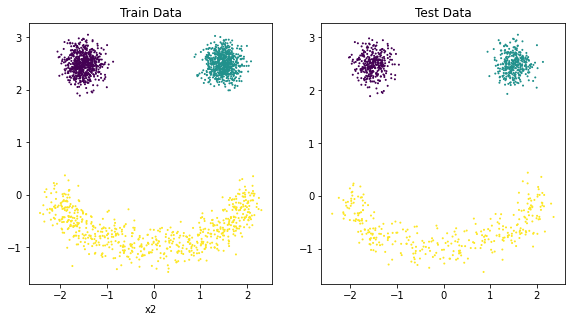

Dataset 2


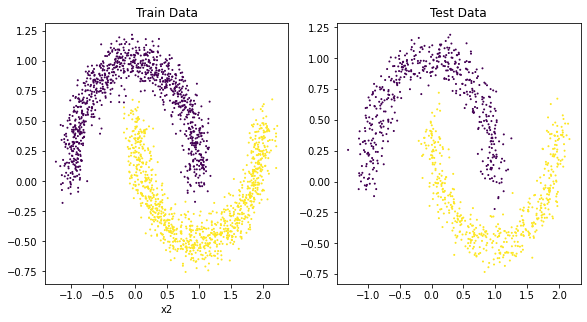

In [20]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

Some packages that you may find useful are imported below. Please check them, you may or may not use them. Feel free to import more if you need to.


In [21]:
import deepul.pytorch_util as ptu
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import trange, tqdm_notebook
import copy
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from scipy.stats import norm

## RealNVP [30 pts]
In this part, we want to train a flow with the following structure: 
$(z_1, z_2) = (f_{\theta, 1} \circ \cdots \circ f_{\theta, n})$, 
where each $f_{\theta, i}$ is an affine transformation of 1 dimension, conditioned on the other, and $z \sim N(0, I)$. According to [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803) Section 4.1, there's a particularly good way to parameterize the affine transformation:

Assuming that we're conditioning on $x_1$ and transforming $x_2$, we have 

- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters.


**Implementation Tips:**


*   Each affine transformation has learned scale, shift parameters as well as a 2 hidden layer MLP (this is the $g_\theta$) . Use 64 as the hidden sizes.
*   Affine transformations will have a mask that masks either left or the right side of the input
*   Use 6 affine transformation layers, alternating the masking pattern.
*   You need to implement the reverse passes for these modules for invertability.
*   Train for 250 epochs with a learning rate of 5e-3




**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3.   Show a heatmap of the densities learned by your model
4.   Show what the training set looks like when mapped to the latent space.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

**Hint:** First, create a class that implements the Affine Transformation. Then, you may pass your input through these affine transformations in the RealNVP flow.

In [ ]:
class MLP(nn.Module):
  """ YOUR CODE HERE """

class AffineTransform(nn.Module):
  """ YOUR CODE HERE """

class RealNVP(nn.Module):
  """ YOUR CODE HERE """

In [ ]:
def q1(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in R^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  """ YOUR CODE HERE """
  # create data loaders

  # create the model

  # train your model

  # heatmap (you may uncomment below and use it to generate your densities)
  # beware that real_nvp variable in this code corresponds to your model and it needs to implement the log_prob function in order for this code to work
  # dx, dy = 0.025, 0.025
  # if dset_id == 1:  # face
  #     x_lim = (-4, 4)
  #     y_lim = (-4, 4)
  # elif dset_id == 2:  # two moons
  #     x_lim = (-1.5, 2.5)
  #     y_lim = (-1, 1.5)
  # y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
  #                 slice(x_lim[0], x_lim[1] + dx, dx)]
  # mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
  # densities = np.exp(ptu.get_numpy(real_nvp.log_prob(mesh_xs)))

  # generate the latents
  

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Final Test Loss: 1.4094


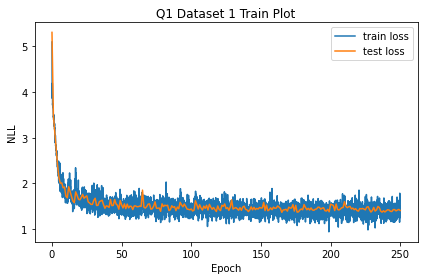

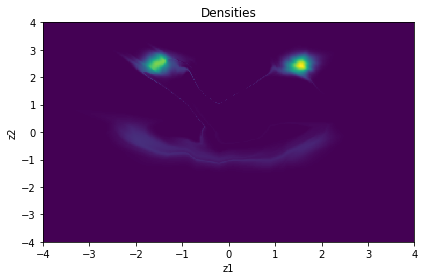

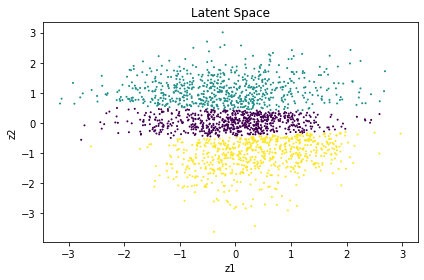

In [25]:
q1_save_results(1, q1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

Final Test Loss: 1.1118


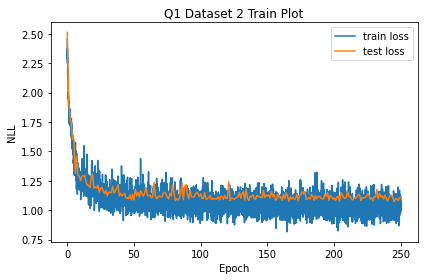

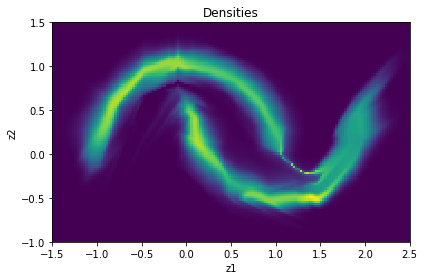

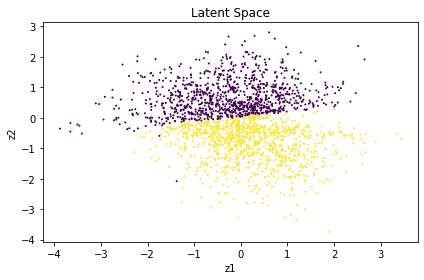

In [26]:
q1_save_results(2, q1)

### Visualizing latent space after each affine transformation [10 pts]

Now, you will visualize the latent space after each layer. For this, you will train your model again using the same setup as before. After training, you will visualize the output of each affine transformation layer using the `show_latents` function that is already provided to you. Here is a pseudocode for you to follow:

```
train_data, train_labels, test_data, test_labels = q1_sample_data_1()
initialize dataloaders
initialize model
train model for 250 epochs

z_0 = train_data converted to float & cuda tensor
for each affine transform:
    z_0 = output of affine transform
    latent = z_0 converted to numpy
    show_latents(latent, train_labels, layer_idx)
```



`show_latents` function is already provided. Please fill out and execute the next cell to visualize the latents. Make sure to pass the `layer_idx` argument (this will be `0,1,2,3,4,5` for each layer respectively) to the `show_latents` function as this function will save these plots using these indexes. **Make sure to include these plots in your latex report.**


In [33]:
def show_latents(latents, labels, title='Latent Space After Layer ', layer_idx = 0):
    plt.figure()
    title = title + str(layer_idx)
    plt.title(title)
    plt.scatter(latents[:, 0], latents[:, 1], s=1, c=labels)
    plt.xlabel('z1')
    plt.ylabel('z2')
    savefig(f'results/q1_latent_space_layer_{layer_idx}.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch:   0%|          | 0/250 [00:00<?, ?it/s]

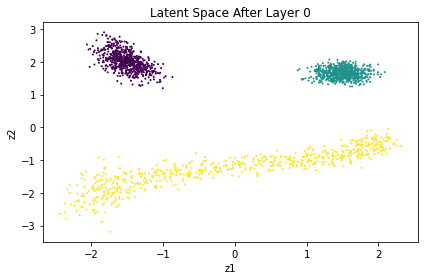

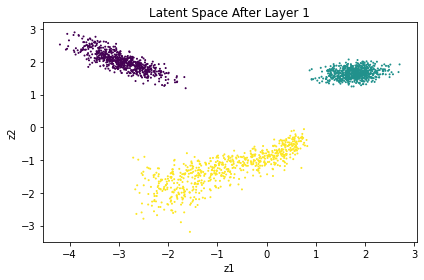

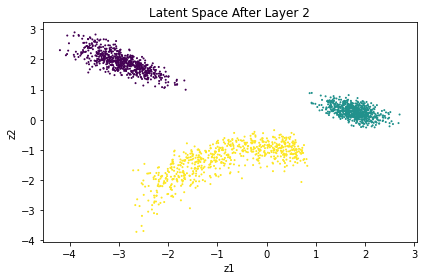

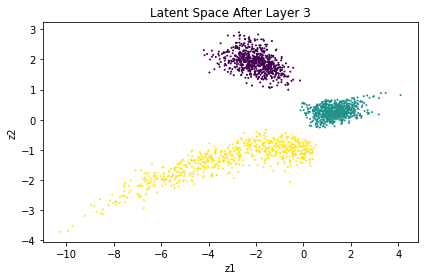

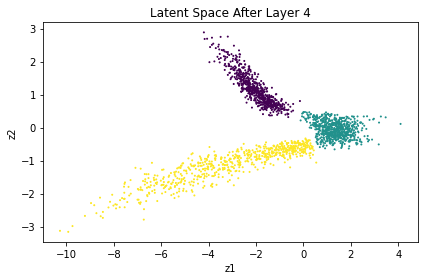

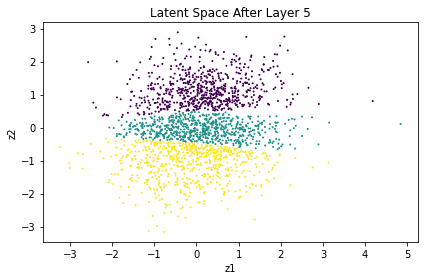

In [35]:
train_data, train_labels, test_data, test_labels = q1_sample_data_1()

""" YOUR CODE HERE """
# Create dataloaders
# Initialize model
# Train the model

# Visualize the latents

 ### <font color='red'> Inline Question 1 </font>

*   What does a latent space mean. What are your observations about these latent spaces after each layer? Please briefly explain.

<font color='red'> Your Answers </font>


# Question 2: VAEs on Images
In this question, you will train different VAE models on a 32x32 quantized version of the Celeb-A dataset. The pixel values are quantized to 2 bits per color channel, they are in the set of {1, 2, 3, 4} Execute the cell below to visualize the dataset.

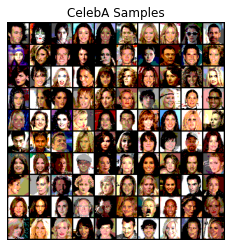

In [4]:
visualize_q2_q3_data()

## Part (a) Vanilla VAE [30 pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 64, learning rate $10^{-3}$, and an Adam optimizer, train for 20 epochs




**You will provide the following deliverables**

1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode), code is already provided
5. Interpolations in 3 different latent dimensions in your latent space, code is already provided




### Solution
Fill out the classes below, some class headers are already provided to you.

The following function rescales the data points to [-1, 1] range. You need to do this scaling when you're feeding your data to the encoder.

In [ ]:
def rescale(x):
    x /= 4.0
    x = 2 * x - 1
    return x

In [ ]:
class ConvEncoder(nn.Module):
  ###################### PSEUDOCODE ##########################
  # Encoder
  #   conv2d(3, 32, 3, 1, 1)
  #   relu()
  #   conv2d(32, 64, 3, 2, 1) # 16 x 16
  #   relu() 
  #   conv2d(64, 128, 3, 2, 1) # 8 x 8
  #   relu()
  #   conv2d(128, 256, 3, 2, 1) # 4 x 4
  #   relu()
  #   flatten()
  #   linear(4 * 4 * 256, 2 * latent_dim)
  """ YOUR CODE HERE """

In [ ]:
class ConvDecoder(nn.Module):
  ###################### PSEUDOCODE ##########################
  # Decoder
  #   linear(latent_dim, 4 * 4 * 128)
  #   relu()
  #   reshape(4, 4, 128)
  #   transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
  #   relu()
  #   transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
  #   relu()
  #   transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
  #   relu()
  #   conv2d(32, 3, 3, 1, 1)
  """ YOUR CODE HERE """

In [ ]:
class VanillaVAE(nn.Module):
  """ YOUR CODE HERE """
  # Use ConvEncoder and ConvDecoder in init function
  # encoder = ConvEncoder
  # decoder = ConvDecoder

  # implement loss function (ELBO)

  # sampling function is already provided to you, you may wish to modify it if your model implementation is not compatible
  def sample(self, n):
      with torch.no_grad():
          z = torch.randn(n, self.latent_size).cuda()
          samples = torch.clamp(self.decoder(z), -1, 1)
      return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

Fill out the following function. Here is a pseudocode:



```
train_loader = torch.utils.data.DataLoader(train_data, ...)
test_loader = torch.utils.data.DataLoader(train_data, ...)
model = VanillaVAE(...).cuda()
train_losses, test_losses = train_epochs(train_loader, test_loader, ...)
sample = model.sample(100) * 255.

reconstructions = ... (code is provided)
interpolations = ... (code is provided)
return train_losses, test_losses, samples, reconstructions, interpolations

```



In [ ]:
def q2_a(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}, code is already provided for this
    - a (50, 32, 32, 3) numpy array of interpolations, code is already provided for this
    """

    """ YOUR CODE HERE """

    # The following lines are for creating reconstructions and interpolations from the test set
    # They should be working if you created your encoder, decoder correctly and named them encoder, decoder
    # Feel free to modify them if your model is not compatible with this piece of code
    x = next(iter(test_loader))[:50].cuda().float()
    with torch.no_grad():
        x = rescale(x)
        z, _ = model.encoder(x)
        x_recon = torch.clamp(model.decoder(z), -1, 1)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

    x = next(iter(test_loader))[11:12].float().cuda()
    good_indices = [2,8,11,15]
    with torch.no_grad():
        x = rescale(x)
        z, _ = model.encoder(x)
        z1 = torch.clone(z)
        out_interps = []
        for dim in good_indices:
          all_interps = []
          for alpha in np.linspace(0, 5, 10):
              z3 = torch.clone(z1)
              z3[:,dim] = z1[:,dim] + alpha
              interp = model.decoder(z3)
              all_interps.append(interp)
          all_interps = torch.stack(all_interps, dim=1).view(-1, 3, 32, 32)
          out_interps.append(all_interps)
    out_interps = torch.stack(out_interps, dim=0)
    out_interps = out_interps.view(-1, 3, 32, 32)
    out_interps = out_interps * 0.5 + 0.5
    interps = out_interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    return train_losses, test_losses, samples, reconstructions, interps

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

Final -ELBO: 271.1649, Recon Loss: 240.8333, KL Loss: 30.3316


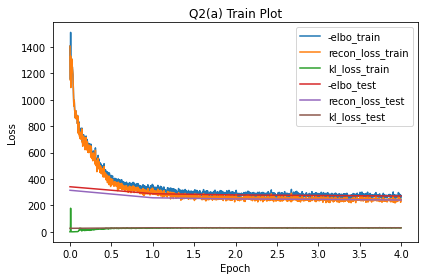

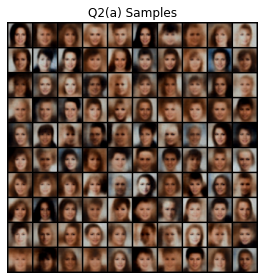

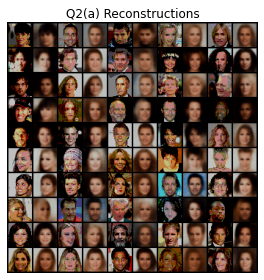

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


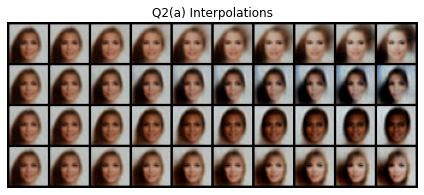

In [13]:
q2_save_results('a', q2_a)

## Part (b) Beta VAE [10 pts]
In this part, you will implement Beta-VAE. This is just an extension to your VanillaVAE implementation. The architecture will be exactly the same, but you will include the Beta term in the ELBO objective this time, by multiplying the KL term with this Beta weight. Use `beta = 16`. Everything else remains the same.

**You will provide the following deliverables (same as part a)**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode), code is already provided
5. Interpolations in 3 different latent dimensions in your latent space, code is already provided



### Solution
Fill out the classes below, some class headers are already provided to you.

In [ ]:
class BetaVAE(nn.Module):
  """ YOUR CODE HERE """
  # Use ConvEncoder and ConvDecoder in init function
  # encoder = ConvEncoder
  # decoder = ConvDecoder
  # beta = beta

  # implement loss function (ELBO)

  # sampling function is already provided to you, you may wish to modify it if your model implementation is not compatible
  def sample(self, n):
      with torch.no_grad():
          z = torch.randn(n, self.latent_size).cuda()
          samples = torch.clamp(self.decoder(z), -1, 1)
      return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

Fill out the following function. Here is a pseudocode:



```
train_loader = torch.utils.data.DataLoader(train_data, ...)
test_loader = torch.utils.data.DataLoader(train_data, ...)
model = BetaVAE(...).cuda()
train_losses, test_losses = train_epochs(train_loader, test_loader, ...)
sample = model.sample(100) * 255.

reconstructions = ... (code is provided)
interpolations = ... (code is provided)
return train_losses, test_losses, samples, reconstructions, interpolations

```



In [ ]:
def q2_b(train_data, test_data):
    """
    train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (50, 32, 32, 3) numpy array of interpolations, the code is already provided for this
    """

    """ YOUR CODE HERE """
    
    # The following lines are for creating reconstructions and interpolations from the test set
    # They should be working if you created your encoder, decoder correctly and named them encoder, decoder
    # Feel free to modify them if your model is not compatible with this piece of code
    x = next(iter(test_loader))[:50].cuda().float()
    with torch.no_grad():
        x = rescale(x)
        z, _ = model.encoder(x)
        x_recon = torch.clamp(model.decoder(z), -1, 1)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255

    x = next(iter(test_loader))[11:12].float().cuda()
    good_indices = [2,8,11,15]
    with torch.no_grad():
        x = rescale(x)
        z, _ = model.encoder(x)
        z1 = torch.clone(z)
        out_interps = []
        for dim in good_indices:
          all_interps = []
          for alpha in np.linspace(0, 5, 10):
              z3 = torch.clone(z1)
              z3[:,dim] = z1[:,dim] + alpha
              interp = model.decoder(z3)
              all_interps.append(interp)
          all_interps = torch.stack(all_interps, dim=1).view(-1, 3, 32, 32)
          out_interps.append(all_interps)
    out_interps = torch.stack(out_interps, dim=0)
    out_interps = out_interps.view(-1, 3, 32, 32)
    out_interps = out_interps * 0.5 + 0.5
    interps = out_interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    return train_losses, test_losses, samples, reconstructions, interps

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

Final -ELBO: 546.7735, Recon Loss: 430.0163, KL Loss: 3.6487


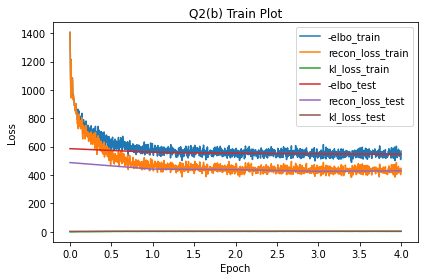

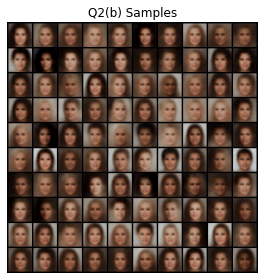

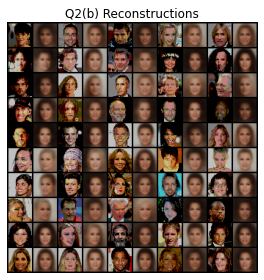

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


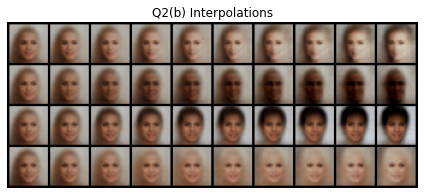

In [16]:
q2_save_results('b', q2_b)

 ### <font color='red'> Inline Question 2 </font>

*   Compare the latent space interpolations for Vanilla and Beta VAEs. What are the differences in terms of disentanglement when you move along one dimension in the latent code? Please briefly talk about your observations and your explanations.

<font color='red'> Your Answers </font>


# Question 3: VQ-VAE [20 pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the CelebA dataset from the previous Question. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

For this part, you will only fill out the encoder, decoder and the codebook of the VQ-VAE. The rest of the models (PixelCNN prior) and the training loops are already provided to you. You will experiment with the choice of codebook size and report your results.


*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   You may find the following tips helpful for mapping the output of the encoder to the codebook quantized feature vectors
    *   Use argmin of the squared distance $argmin((z_e(x) - Q) ^ 2)$ to find the closest vector in the codebook $q$ to the output of the encoder $z_e(x)$
    *   Rewrite $(z_e(x) - q) ^ 2$ as $z_e^2(x) - 2 z_e(x) q+ q^2$
    *   Use torch.matmul to compute the term $2 z_e(x) q$ of the aforementioned equation
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, to implement the straight-through estimator, we create a connection in the computation graph between the output of the encoder and the input of the decoder by adding and subtracting $z_e(x)$ to $z_q(x)$ as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch

## Solution
The following cells include the training loops and the PixelCNN prior. Please execute these cells.

In [ ]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

In [ ]:
def train(model, train_loader, optimizer, epoch, quiet, grad_clip=None, prior=False):
    model.train()

    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x in train_loader:
        x = x.cuda()
        if not prior:
          x = x.float()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'

        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return losses


def eval_loss(model, data_loader, quiet, prior):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            if not prior:
              x = x.float()
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses


def train_epochs(model, train_loader, test_loader, train_args, quiet=False, prior=False):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = OrderedDict(), OrderedDict()
    for epoch in range(epochs):
        model.train()
        train_loss = train(model, train_loader, optimizer, epoch, quiet, grad_clip, prior=prior)
        test_loss = eval_loss(model, test_loader, quiet, prior=prior)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses

In [ ]:
def rescale(x):
    x /= 4.0
    x = 2 * x - 1
    return x

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1)
        )
      
    def forward(self, x):
        return x + self.net(x)

class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()


class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)
        return out

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1


class PixelCNNResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.ModuleList([
            LayerNorm(dim),
            nn.ReLU(),
            MaskConv2d('B', dim, dim // 2, 1),
            LayerNorm(dim // 2),
            nn.ReLU(),
            MaskConv2d('B', dim // 2, dim // 2, 3, padding=1),
            LayerNorm(dim // 2),
            nn.ReLU(),
            MaskConv2d('B', dim // 2, dim, 1)
        ])

    def forward(self, x):
        out = x
        for layer in self.block:
            out = layer(out)
        return x + out


class PixelCNN(nn.Module):
    def __init__(self, input_shape, code_size, dim=256, n_layers=7):
        super().__init__()
        self.embedding = nn.Embedding(code_size, dim)
        model = nn.ModuleList([MaskConv2d('A', dim, dim, 7, padding=3),
                               LayerNorm(dim), nn.ReLU()])
        for _ in range(n_layers - 1):
            model.append(PixelCNNResBlock(dim))
        model.extend([LayerNorm(dim), nn.ReLU(), MaskConv2d('B', dim, 512, 1),
                      nn.ReLU(), MaskConv2d('B', 512, code_size, 1)])
        self.net = model
        self.input_shape = input_shape
        self.code_size = code_size

    def forward(self, x):
        out = self.embedding(x).permute(0, 3, 1, 2).contiguous()
        for layer in self.net:
            out = layer(out)
        return out

    def loss(self, x):
        return OrderedDict(loss=F.cross_entropy(self(x), x))

    def sample(self, n):
        samples = torch.zeros(n, *self.input_shape).long().cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, r, c]
                    logits = F.softmax(logits, dim=1)
                    samples[:, r, c] = torch.multinomial(logits, 1).squeeze(-1)
        return samples

Fill out the following classes. Here, you need to implement the Codebook (Quantize), the Encoder and the Decoder. Here is a pseudocode for you to follow:

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
batch_norm2d(dim)

VQEncoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

VQDecoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32

Quantize
    init:
        embedding = nn.Embedding(size, code_dim)
        Uniformly initalize the embedding weights in the rage [-1./size, 1./size]

    forward:
        flatten input
        compute distances with the latents in the codebook
        select the minimum distance latent
        return quantized, (quantized - z).detach(), encoding_indices


```

In [ ]:
class VQEncoder(nn.Module):
    """ YOUR CODE HERE """

In [ ]:
class VQDecoder(nn.Module):
    """ YOUR CODE HERE """

In [ ]:
class Quantize(nn.Module):
    def __init__(self, size, code_dim):
        super().__init__()
        """ YOUR CODE HERE """

    def forward(self, z):
        """ YOUR CODE HERE """
        # You should return the quantized latent, the straight-through estimator and the
        # indices after sorting by the distance, in the [B,H,W] shape

In [ ]:
class VectorQuantizedVAE(nn.Module):
    def __init__(self, code_dim, code_size):
        super().__init__()
        self.code_size = code_size

        self.encoder = VQEncoder()

        self.codebook = Quantize(code_size, code_dim)

        self.decoder = VQDecoder()

    def encode_code(self, x):
        with torch.no_grad():
            x = rescale(x)
            z = self.encoder(x)
            indices = self.codebook(z)[2]
            return indices

    def decode_code(self, latents):
        with torch.no_grad():
            latents = self.codebook.embedding(latents).permute(0, 3, 1, 2).contiguous()
            return self.decoder(latents).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5

    def forward(self, x):
        z = self.encoder(x)
        e, e_st, _ = self.codebook(z)
        x_tilde = self.decoder(e_st)

        diff1 = torch.mean((z - e.detach()) ** 2)
        diff2 = torch.mean((e - z.detach()) ** 2)
        return x_tilde, diff1 + diff2

    def loss(self, x):
        x = rescale(x)
        x_tilde, diff = self(x)
        recon_loss = F.mse_loss(x_tilde, x)
        loss = recon_loss + diff
        return OrderedDict(loss=loss, recon_loss=recon_loss, reg_loss=diff)

In [ ]:
def q3(train_data, test_data):

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=False)

    code_dim, code_size = 256, 128
    vqvae = VectorQuantizedVAE(code_dim, code_size).cuda()
    train_losses, test_losses = train_epochs(vqvae, train_loader, test_loader,
                                             dict(epochs=2, lr=1e-3, grad_clip=1), quiet=True)
    vqvae_train_losses, vqvae_test_losses = train_losses['loss'], test_losses['loss']

    def create_prior_dataset(data_loader):
        prior_data = []
        with torch.no_grad():
            for x in data_loader:
                x = x.cuda().float()
                z = vqvae.encode_code(x)
                prior_data.append(z.long())
        return torch.cat(prior_data, dim=0)

    prior = PixelCNN(code_size=code_size, input_shape=(8, 8), dim=128, n_layers=10).cuda()
    prior_train_data, prior_test_data = create_prior_dataset(train_loader), create_prior_dataset(test_loader)
    prior_train_loader = data.DataLoader(prior_train_data, batch_size=128, shuffle=True)
    prior_test_loader = data.DataLoader(prior_test_data, batch_size=128)
    prior_train_losses, prior_test_losses = train_epochs(prior, prior_train_loader, prior_test_loader,
                                                         dict(epochs=2, lr=1e-3, grad_clip=1), quiet=True, prior=True)
    prior_train_losses, prior_test_losses = prior_train_losses['loss'], prior_test_losses['loss']

    samples = prior.sample(100).long()
    samples = vqvae.decode_code(samples) * 255

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        x = x.float()
        z = vqvae.encode_code(x)
        x_recon = vqvae.decode_code(z)
    x = x.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

    return vqvae_train_losses, vqvae_test_losses, prior_train_losses, prior_test_losses, samples, reconstructions

### Results
Once you've finished all parts of the model, execute the cells below to visualize and save your results

VQ-VAE Final Test Loss: 0.1015
PixelCNN Prior Final Test Loss: 2.0192


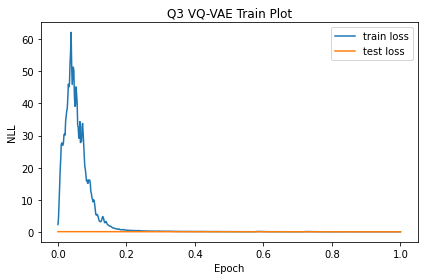

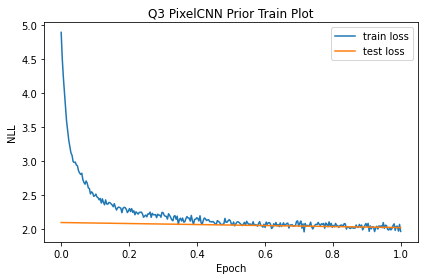

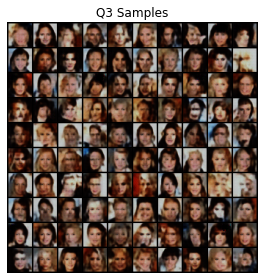

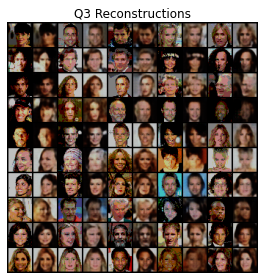

In [ ]:
q3_save_results(q3)

### Visualizing Histogram of Codebook Entries

Now, we will visualize how many of the codebook entries our model uses and compare them when we use different codebook sizes. For this part, you need to complete the following function. The first part of the function is already provided to you. You will fill out the rest of the function, you can follow this pseudocode:

```
initialize indices as empty list
for each batch in test loader:
    convert to float & cuda tensors
    get the indices using encode_code() function of vqvae
    convert to cpu and numpy array, flatten it
    append to indices
horizontally stack indices to have one flat numpy array
return indices
```
Once you complete this function, please execute the three cells below that. They will be creating a histogram of these indices and save these plots. **You need to download these and add them to your latex report.**

In [ ]:
def compute_codebook_indices(K=256):
    train_data, test_data = get_q2_q3_data()
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=False)

    code_dim, code_size = 256, K
    vqvae = VectorQuantizedVAE(code_dim, code_size).cuda()
    train_losses, test_losses = train_epochs(vqvae, train_loader, test_loader,
                                              dict(epochs=2, lr=1e-3, grad_clip=1), quiet=True)
    
    """ YOUR CODE HERE """
    # Compute the codebook indices by looping over the test loader. Return these indices as a flattened numpy array


In [ ]:
def plot_codebook_histogram(K=256):
    indices = compute_codebook_indices(K=K)
    unique, counts = np.unique(indices, return_counts=True)
    plt.title(f'{len(unique)} unique codebook entries used')
    plt.hist(indices, np.arange(K+1));
    savefig(f'results/q3_codebook_histogram_{K}.png')

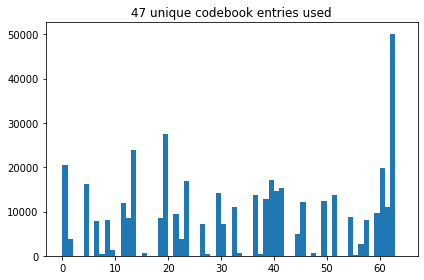

In [ ]:
plot_codebook_histogram(K=64)

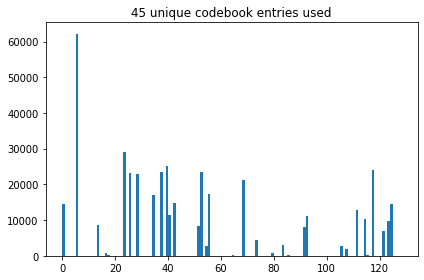

In [ ]:
plot_codebook_histogram(K=128)

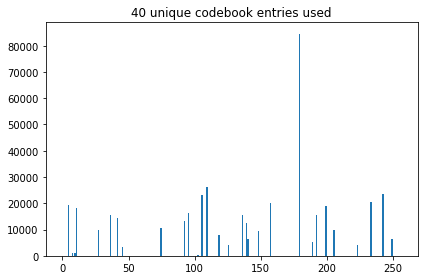

In [ ]:
plot_codebook_histogram(K=256)

 ### <font color='red'> Inline Question 3 </font>

*   Observe the histograms and the number of unique codebook entries used for each setup. Does the model utilize every entry of this codebook? Why do you think that this happens? Please briefly explain.

<font color='red'> Your Answers </font>


# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)

# What and How to Submit

1. Save your notebook and clear all the cells: Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells).
2. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. Make sure all your solutions especially the coding parts are displayed in the pdf, it's okay if the provided codes get cut off because lines are not wrapped in code cells).
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. Name your pdf as **username_assignment2.pdf**, e.g. eacikgoz_assignment2.pdf.
5. Download a .ipynb version of your notebook, please name this as **username_assignment2.ipynb**, e.g. eacikgoz17_assignment2.ipynb.
6. You must submit both of your **username_assignment2.pdf** and **username_assignment2.ipynb** files to the Blackboard, before the deadline. Please note that failing to submit a PDF version of your Jupyter notebook, by following the steps above, will result in a deduction of points.
7. Finally, submit your overleaf report in PDF format as **username_assignment2_report.pdf**.

At the end, you msut have three different deliverables from Blackboard: (i) your jupyter notebook, (ii) PDF version of your jupyter notebook, (iii) PDF version of your overleaf report.

*This assignment is adapted from UC Berkeley [CS294-158-SP20](https://sites.google.com/view/berkeley-cs294-158-sp20/home)*